In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")

Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from matplotlib.patches import Patch
from pytorch_lightning import seed_everything
from returns.result import Failure, Result, Success
from sklearn.pipeline import Pipeline

seed_everything(42, workers=True)

import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

import hydro_forecasting.experiment_utils.checkpoint_manager as checkpoint_manager
from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.model_evaluation.visualization import (
    plot_basin_performance_scatter,
    plot_horizon_performance_bars,
    plot_model_cdf_grid,
)
from hydro_forecasting.models.dummy import LitRepeatLastValues, RepeatLastValuesConfig
from hydro_forecasting.models.ealstm import EALSTMConfig, LitEALSTM
from hydro_forecasting.models.tft import LitTFT, TFTConfig
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.models.tsmixer import LitTSMixer, TSMixerConfig
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from hydro_forecasting.preprocessing.normalize import NormalizeTransformer
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer


Seed set to 42


---

In [3]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [4]:
REGIONS = ["CA"]

COUNTRY = "tajikistan"

MODEL_TYPES = [
    "tft",
    "ealstm",
    "tide",
    "tsmixer",
]

In [5]:
ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/ealstm.yaml"
tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tft.yaml"
tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tide.yaml"
tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tsmixer.yaml"


tft_hp = hp_from_yaml("tft", tft_yaml)
tide_hp = hp_from_yaml("tide", tide_yaml)
ealstm_hp = hp_from_yaml("ealstm", ealstm_yaml)
tsmixer_hp = hp_from_yaml("tsmixer", tsmixer_yaml)

The following parameters were not found in the YAML file and will use defaults:
  - hidden_continuous_size (model-specific)
  - quantiles (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - future_forcing_projection_size (model-specific)
  - past_feature_projection_size (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - bias (model-specific)
  - bidirectional (model-specific)
  - bidirectional_fusion (model-specific)
  - future_hidden_size (model-specific)
  - future_layers (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)


In [6]:
TFT_config = TFTConfig(**tft_hp)
EALSTM_config = EALSTMConfig(**ealstm_hp)
TiDE_config = TiDEConfig(**tide_hp)
TSMixer_config = TSMixerConfig(**tsmixer_hp)

dummy_config = RepeatLastValuesConfig(
    input_len=ealstm_hp["input_len"],
    input_size=ealstm_hp["input_size"],
    output_len=ealstm_hp["output_len"],
)

---

In [7]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


country_ids = load_basin_ids(COUNTRY)
country_ids = [id for id in country_ids if id != "CA_15030"]

In [8]:
print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 16 total CA basins in tajikistan


---

In [9]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": static_features},
}

In [10]:
region_time_series_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/timeseries/csv/{region}"
    for region in REGIONS
}

region_static_attributes_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/attributes/{region}" for region in REGIONS
}

In [11]:
tft_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tft_hp["input_len"],
    output_length=tft_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tide_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tsmixer_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tsmixer_hp["input_len"],
    output_length=tsmixer_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

ealstm_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=ealstm_hp["input_len"],
    output_length=ealstm_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)


In [12]:
def get_checkpoint_for_model(model_type: str, checkpoint_folder: Path, select_overall_best: bool = True):
    """
    Function to get the best checkpoint for a given model type
    """
    result = checkpoint_manager.get_checkpoint_path_to_load(
        base_checkpoint_load_dir=checkpoint_folder, model_type=model_type, select_overall_best=select_overall_best
    )
    return result


def unwrap(checkpoint: Result) -> Path:
    """
    Function to unwrap the checkpoint result
    """
    if isinstance(checkpoint, Failure):
        print(f"Failed to load checkpoint: {checkpoint.failure()}")
        return None
    elif isinstance(checkpoint, Success):
        return checkpoint.unwrap()


pretrained_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_{COUNTRY.lower()}/checkpoints"
)

finetuned_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low-medium-hii_{COUNTRY.lower()}/checkpoints"
)

benchmark_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_{COUNTRY.lower()}/checkpoints"
)

In [13]:
tft_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)


tsmixer_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)

tft_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
tsmixer_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)

tft_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

ealstm_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

tsmixer_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

print(
    f"Pretrained checkpoints: {tide_pretrained_checkpoint}, {ealstm_pretrained_checkpoint}, {tsmixer_pretrained_checkpoint}, {tft_pretrained_checkpoint}"
)
print(
    f"Finetuned checkpoints: {tide_finetuned_checkpoint}, {ealstm_finetuned_checkpoint}, {tsmixer_finetuned_checkpoint}, {tft_finetuned_checkpoint}"
)
print(
    f"Benchmark checkpoints: {tide_benchmark_checkpoint}, {ealstm_benchmark_checkpoint}, {tsmixer_benchmark_checkpoint}, {tft_benchmark_checkpoint}"
)

Pretrained checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tide/run_0/attempt_0/tide-run0-attempt_0-epoch=75-val_loss=0.0446.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/ealstm/run_0/attempt_0/ealstm-run0-attempt_0-epoch=43-val_loss=0.0924.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tsmixer/run_0/attempt_0/tsmixer-run0-attempt_0-epoch=41-val_loss=0.0934.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/low-medium-hii/low-medium-hii_tajikistan/checkpoints/tft/run_0/attempt_0/tft-run0-attempt_0-epoch=154-val_loss=0.0380.ckpt
Finetuned checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_low-medium-hii_tajikistan/checkpoints/tide/run_3/attempt_0/tide-run3-attempt_0-epoch=13-val_loss=0.0298.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/

In [14]:
dummy_model = LitRepeatLastValues(config=dummy_config)
ealstm_benchmark_model = LitEALSTM.load_from_checkpoint(ealstm_benchmark_checkpoint, config=EALSTM_config)
tide_benchmark_model = LitTiDE.load_from_checkpoint(tide_benchmark_checkpoint, config=TiDE_config)
tsmixer_benchmark_model = LitTSMixer.load_from_checkpoint(tsmixer_benchmark_checkpoint, config=TSMixer_config)
tft_benchmark_model = LitTFT.load_from_checkpoint(tft_benchmark_checkpoint, config=TFT_config)

ealstm_pretrained_model = LitEALSTM.load_from_checkpoint(ealstm_pretrained_checkpoint, config=EALSTM_config)
tide_pretrained_model = LitTiDE.load_from_checkpoint(tide_pretrained_checkpoint, config=TiDE_config)
tsmixer_pretrained_model = LitTSMixer.load_from_checkpoint(tsmixer_pretrained_checkpoint, config=TSMixer_config)
tft_pretrained_model = LitTFT.load_from_checkpoint(tft_pretrained_checkpoint, config=TFT_config)

ealstm_finetuned_model = LitEALSTM.load_from_checkpoint(ealstm_finetuned_checkpoint, config=EALSTM_config)
tide_finetuned_model = LitTiDE.load_from_checkpoint(tide_finetuned_checkpoint, config=TiDE_config)
tsmixer_finetuned_model = LitTSMixer.load_from_checkpoint(tsmixer_finetuned_checkpoint, config=TSMixer_config)
tft_finetuned_model = LitTFT.load_from_checkpoint(tft_finetuned_checkpoint, config=TFT_config)


# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "ealstm_benchmark": (ealstm_benchmark_model, ealstm_data_module),
    # "ealstm_pretrained": (ealstm_pretrained_model, ealstm_data_module),
    # "ealstm_finetuned": (ealstm_finetuned_model, ealstm_data_module),
    # "tide_benchmark": (tide_benchmark_model, tide_data_module),
    # "tide_pretrained": (tide_pretrained_model, tide_data_module),
    # "tide_finetuned": (tide_finetuned_model, tide_data_module),
    # "tsmixer_benchmark": (tsmixer_benchmark_model, tsmixer_data_module),
    # "tsmixer_pretrained": (tsmixer_pretrained_model, tsmixer_data_module),
    # "tsmixer_finetuned": (tsmixer_finetuned_model, tsmixer_data_module),
    # "tft_benchmark": (tft_benchmark_model, tft_data_module),
    # "tft_pretrained": (tft_pretrained_model, tft_data_module),
    # "tft_finetuned": (tft_finetuned_model, tft_data_module),
    "dummy": (dummy_model, ealstm_data_module),
}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "cpu", "devices": 1, "deterministic": True, "benchmark": False},
)

In [15]:
# Run evaluation
results = evaluator.test_models()

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2025-06-10 19:35:33,242 - hydro_forecasting.data.in_memory_datamodule - INFO - Starting data preparation...
2025-06-10 19:35:33,244 - hydro_forecasting.data.in_memory_datamodule - INFO - Generated Run UUID for current config: e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
2025-06-10 19:35:33,244 - hydro_forecasting.data.in_memory_datamodule - INFO - Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78
2025-06-10 19:35:33,253 - hydro_forecasting.data.in_

Testing ealstm_benchmark...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03726644441485405
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
=== MODEL DATA SOURCE DEBUG ===
Datamodule type: HydroInMemoryDataModule
Datamodule ID: 6001411712
Datamodule config: "batch_size":                             2048
"chunk_size":                             100
"domain_id":                              source
"domain_type":                            source
"forcing_features":                       ['snow_depth_water_equivalent_mean', 'surface_net_solar_radiation_mean', 'surface_net_thermal_radiation_mean', 'potential_evaporation_sum_ERA5_LAND', 'potential_evaporation_sum_FAO_PENMAN_MONTEI

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2025-06-10 19:35:44,592 - hydro_forecasting.data.in_memory_datamodule - INFO - Data preparation has already run.
2025-06-10 19:35:44,599 - hydro_forecasting.data.in_memory_datamodule - INFO - Loading test data for 16 basins...
2025-06-10 19:35:44,620 - hydro_forecasting.data.in_memory_datamodule - INFO - Stage 'test' chunk data loaded for 16 basins. Shape: (26619, 12). Est. Mem: 1.22 MB



=== AFTER INVERSE TRANSFORM ===
Transformed preds shape: (23899, 10)
Transformed preds sample: [0.61217647 0.6089516  0.62317896 0.62907281 0.62731307]
Transformed preds range: nan to nan
Transformed obs sample: [0.5199999  0.73999999 0.5199999  0.5199999  0.55000008]
Transformed obs range: 0.010000 to 16.260004
First sample after inverse - all identical? False
First sample std after inverse: 0.014803
Quick NSE for basin CA_16205: 0.928667
MSE: 0.044052, Obs variance: 0.617559
Testing dummy...


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7074034810066223
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
=== MODEL DATA SOURCE DEBUG ===
Datamodule type: HydroInMemoryDataModule
Datamodule ID: 6001411712
Datamodule config: "batch_size":                             2048
"chunk_size":                             100
"domain_id":                              source
"domain_type":                            source
"forcing_features":                       ['snow_depth_water_equivalent_mean', 'surface_net_solar_radiation_mean', 'surface_net_thermal_radiation_mean', 'potential_evaporation_sum_ERA5_LAND', 'potential_evaporation_sum_FAO_PENMAN_MONTEIT

In [16]:
from typing import Any


def filter_growing_season_polars(eval_results: dict[str, Any]) -> dict[str, Any]:
    """
    Filter evaluation results to include only data from the growing season (April to October), using Polars.

    Args:
        eval_results: dictionary containing evaluation results with a 'df' key,
                      where 'df' is a Polars DataFrame.

    Returns:
        dictionary with filtered Polars DataFrame and original metrics.
    """
    filtered_results = eval_results.copy()

    df = eval_results["df"].clone()

    if "date" not in df.columns:
        raise ValueError("DataFrame must contain a 'date' column.")

    growing_season_df = df.filter((pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() <= 9))

    growing_season_df = df.filter((pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() < 10))

    filtered_results["df"] = growing_season_df

    return filtered_results


def process_seasonal_results_polars(
    results: dict[str, Any],
    evaluator: Any,  # Replace Any with the actual type of TSForecastEvaluator if available
    model_keys: list[str] = None,
) -> dict[str, Any]:
    """
    Process specified model results to get seasonal metrics using Polars DataFrames.

    Args:
        results: dictionary containing results for all models.
        evaluator: Evaluator object with _calculate_overall_metrics and
                   _calculate_basin_metrics methods that can handle Polars DataFrames.
                   (As per evaluators.py, these methods already use Polars)
        model_keys: list of model keys to process. If None, process all keys in results.

    Returns:
        dictionary with seasonal results for the specified models.
    """
    seasonal_results = {}

    if model_keys is None:
        model_keys = list(results.keys())

    # Process each model
    for key in model_keys:
        if key not in results:
            print(f"Warning: Model key '{key}' not found in results. Skipping.")
            continue

        # Filter for growing season using the Polars version
        seasonal_model_results = filter_growing_season_polars(results[key])

        seasonal_model_results["metrics"] = evaluator._calculate_overall_metrics(seasonal_model_results["df"])
        seasonal_model_results["basin_metrics"] = evaluator._calculate_basin_metrics(seasonal_model_results["df"])

        # Store in results dictionary
        seasonal_results[key] = seasonal_model_results

    return seasonal_results


seasonal_results = process_seasonal_results_polars(results, evaluator, model_keys=list(models_and_datamodules.keys()))

In [58]:
print(dummy_model.test_results)

None


In [18]:
sns.set_context(context="paper", font_scale=1.3)

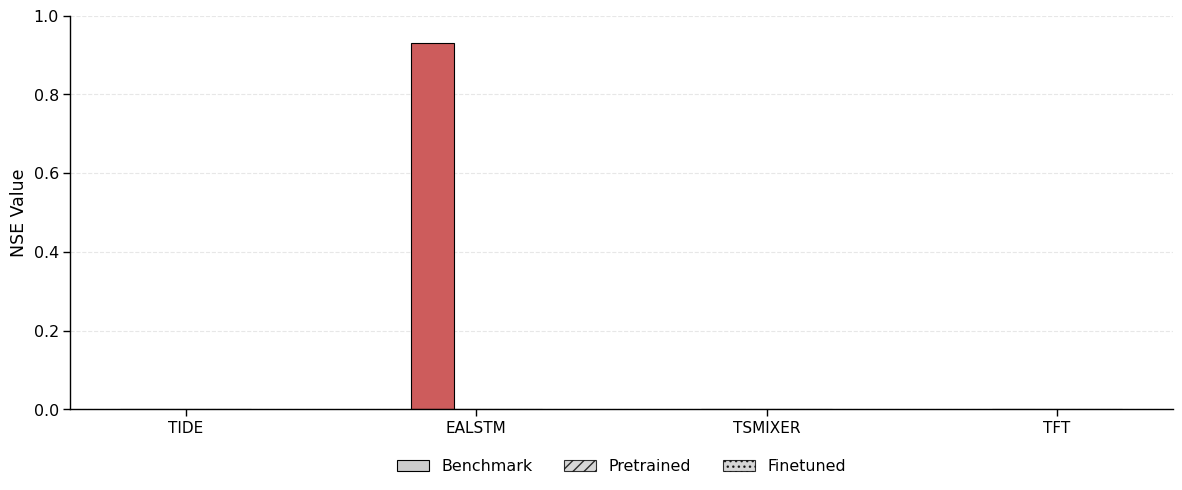

In [19]:
fig, ax = plot_horizon_performance_bars(
    seasonal_results,
    horizon=1,
    metric="NSE",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "pretrained", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 5),
    with_whiskers=False,
    positive_is_better=True,
    dummy_model="dummy"
)
ax.set_ylim(0, 1)
sns.despine()
plt.show()


/Users/cooper/Desktop/hydro-forecasting/src/hydro_forecasting/model_evaluation/visualization.py:392: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


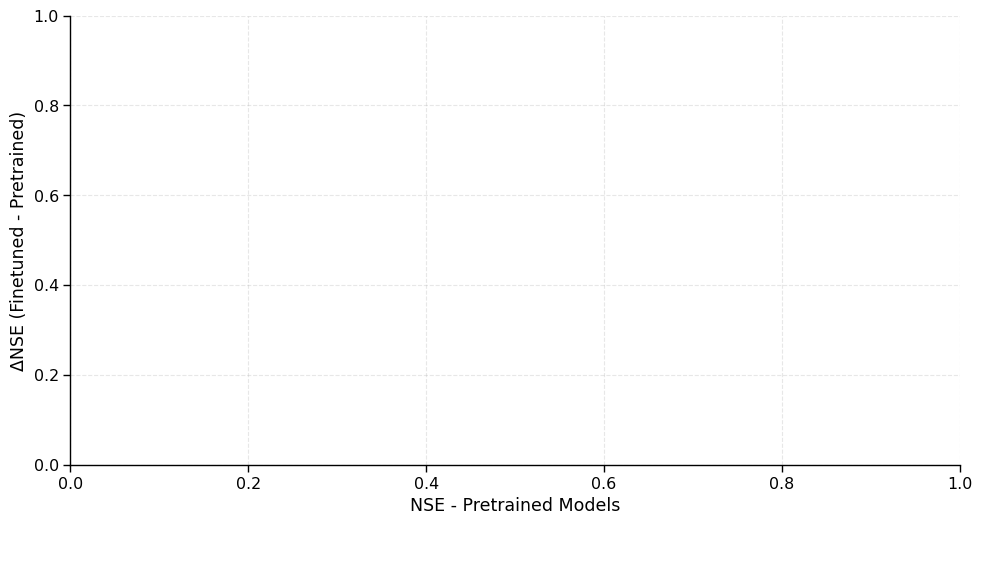

In [20]:
fig, ax = plot_basin_performance_scatter(
    seasonal_results,
    benchmark_pattern="pretrained",
    challenger_pattern="finetuned",
    horizon=10,
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    metric="NSE",
    figsize=(10, 6),
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    debug=False,
)
sns.despine()
plt.show()

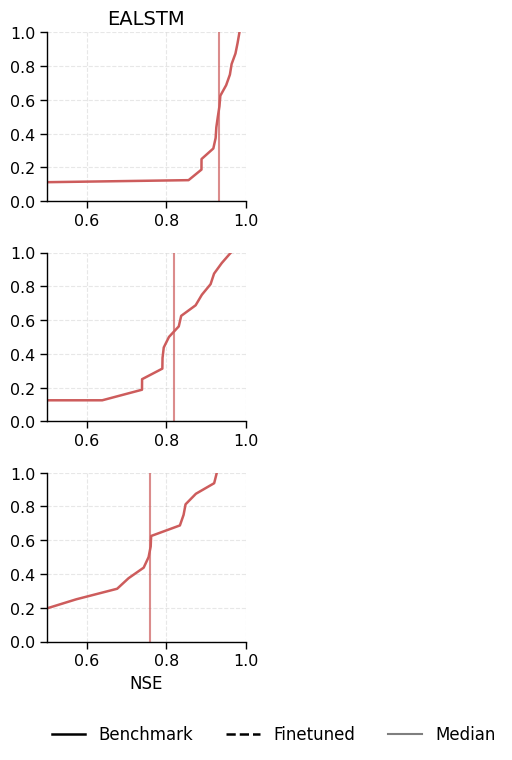

In [21]:
fig, axes = plot_model_cdf_grid(
    seasonal_results,
    horizons=[1, 5, 10],
    metric="NSE",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(10, 8),
)
sns.despine()
plt.savefig(f"/Users/cooper/Desktop/hydro-forecasting/images/preliminary_results/cdf_grid_{COUNTRY}.png", dpi=300, bbox_inches="tight")

plt.show()

# DEBUG